# Hand Gesture Classification


## Imports

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import random

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import sys
import os

# Add src/ to the Python path
sys.path.append(os.path.abspath("../src"))

# Now you can import
from mlflow_logger import log_to_mlflow
from helpers import calculate_metrics
from preprocessing import preprocessing
px.defaults.color_discrete_sequence = px.colors.qualitative.Bold

## Data Loading and Exploration

In [2]:
df = pd.read_csv(r'../data/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


In [3]:
df.shape

(25675, 64)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

In [5]:
labels = df['label'].unique()
labels_freq = df['label'].value_counts().to_list()
fig = px.bar(x=labels, y=labels_freq, labels='freq')
fig.update_layout(
    xaxis_title="Gesture Label",
    yaxis_title="Frequency"
)
fig.update_traces(
    hovertemplate="Label: %{x}<br>Frequency: %{y}<extra></extra>"
)
fig.update_traces(opacity=0.7)
fig.show()

In [6]:
print(f"There are {len(labels)} Classes")

There are 18 Classes


### 2D Gestures visualization

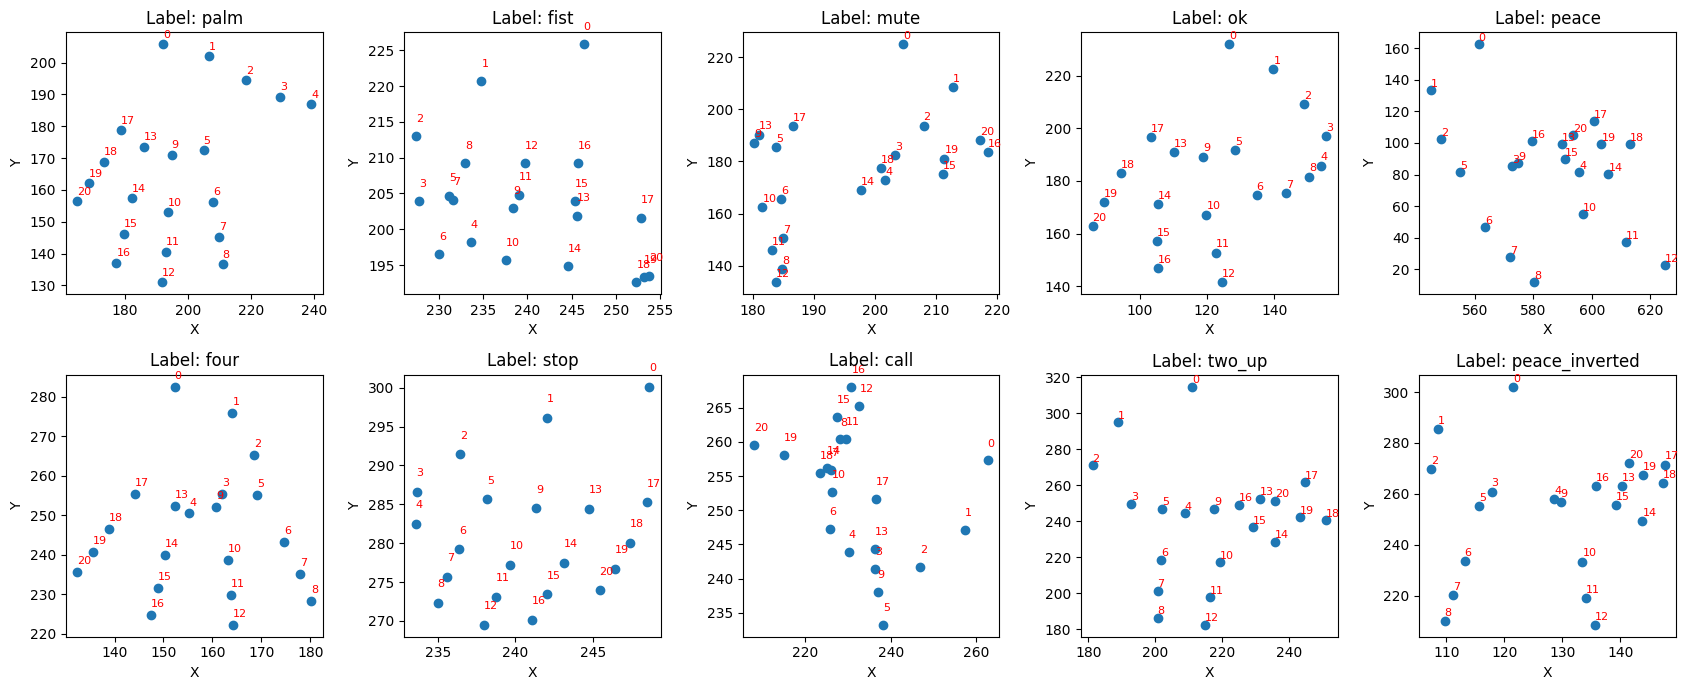

In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np

rand_labels = random.sample(population=labels.tolist(), k=10)
samples = []

# Set figure size first
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(17, 7))

for i, label in enumerate(rand_labels):
    # Select first record for the current label
    sample = df[df["label"] == label].iloc[0][:-1].to_numpy(dtype=float)
    samples.append(sample)

samples = np.array(samples)
samples = samples.reshape((10, 21, 3))  # (num_samples, num_points, xyz)

for idx, record in enumerate(samples):
    x = record[:, 0]
    y = record[:, 1]
    z = record[:, 2]
    
    row = idx // 5
    col = idx % 5
    axs[row, col].scatter(x, y)
    
    # Annotate each point
    for point_idx, (xi, yi) in enumerate(zip(x, y)):
        axs[row, col].text(xi, yi+2, str(point_idx), fontsize=8, color='red')
    
    axs[row, col].set_title(f"Label: {rand_labels[idx]}")
    axs[row, col].set_xlabel("X")
    axs[row, col].set_ylabel("Y")

plt.tight_layout()
plt.show()

### 3D Gestures visualization

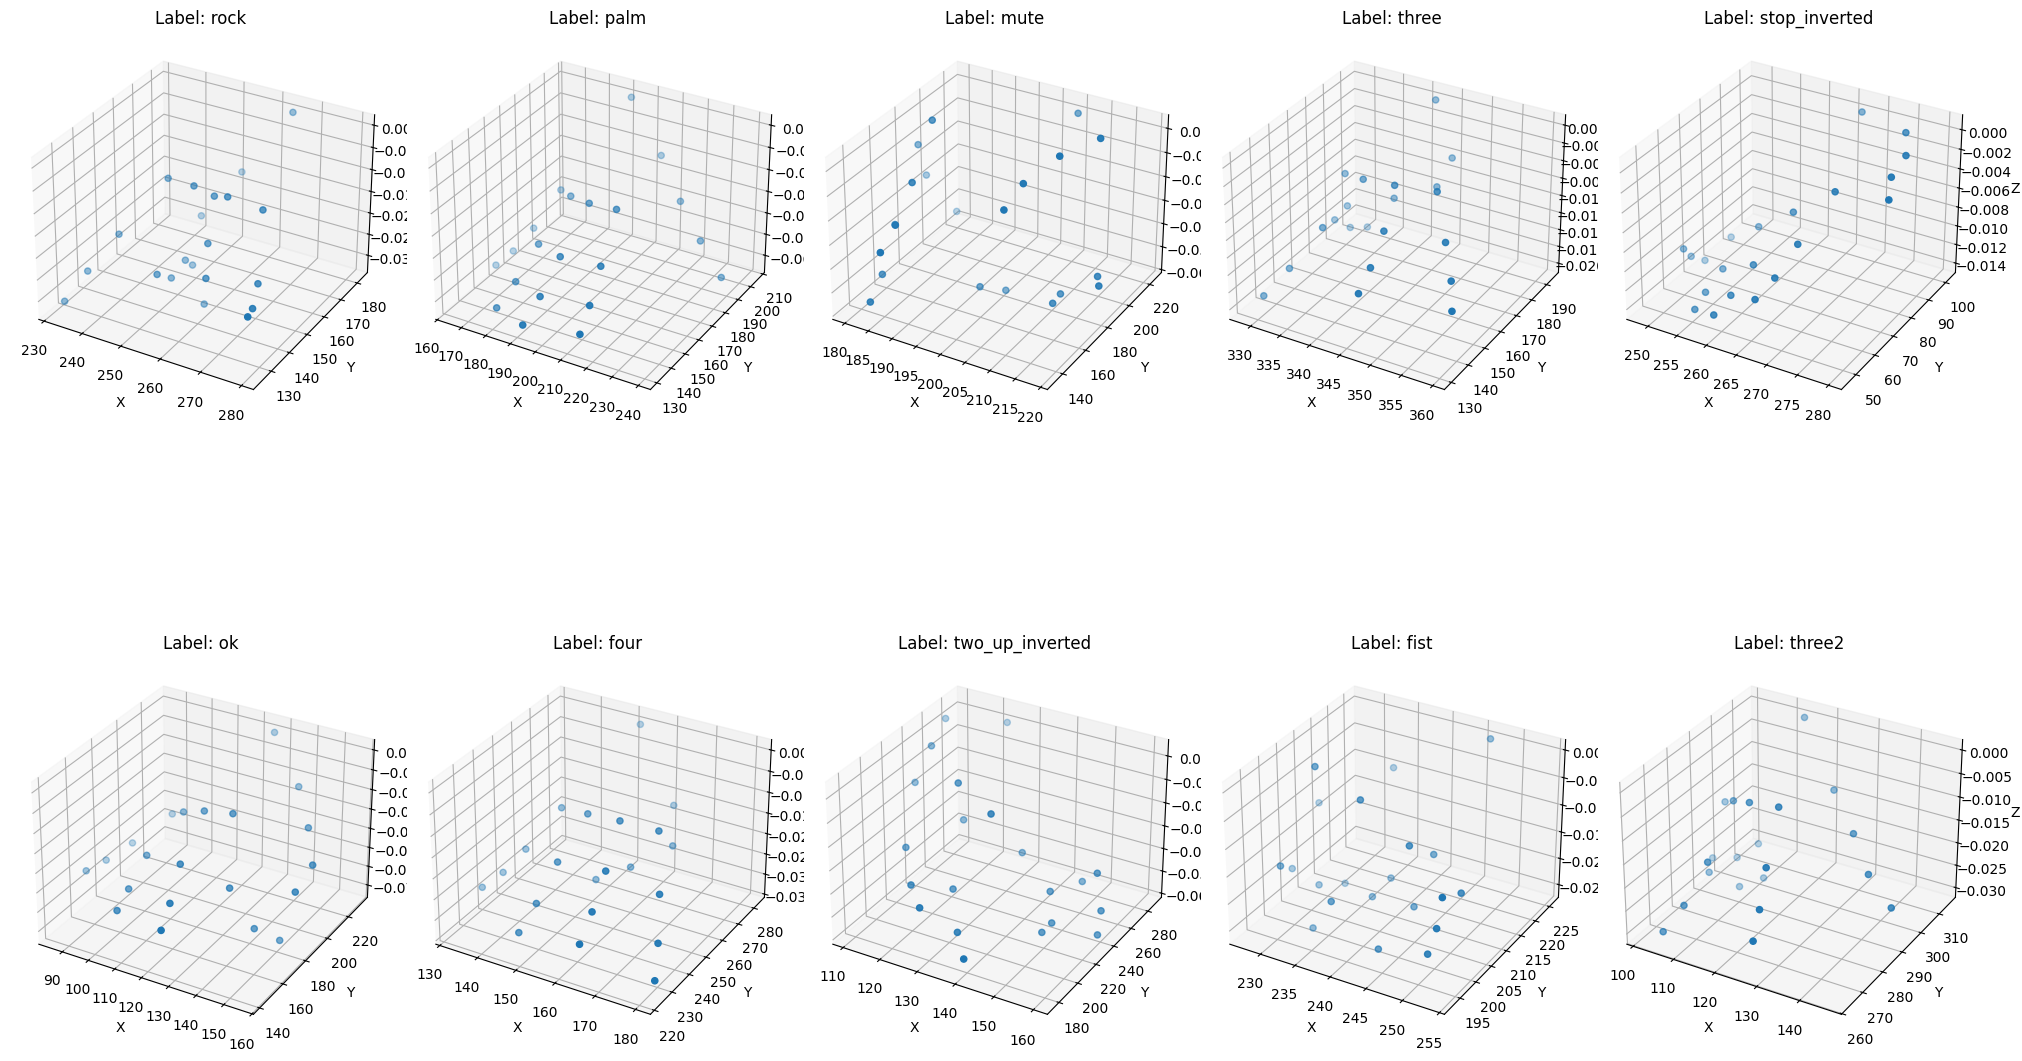

In [8]:
import random
import matplotlib.pyplot as plt
import numpy as np
# from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting

rand_labels = random.sample(population=labels.tolist(), k=10)
samples = []

# Select first record for each random label
for label in rand_labels:
    sample = df[df["label"] == label].iloc[0][:-1].to_numpy(dtype=float)
    samples.append(sample)

samples = np.array(samples)
samples = samples.reshape((10, 21, 3))  # (num_samples, num_points, xyz)

# Create subplots
fig = plt.figure(figsize=(20, 15))

for idx, record in enumerate(samples):
    ax = fig.add_subplot(2, 5, idx + 1, projection='3d')  # 2 rows, 5 cols
    x = record[:, 0]
    y = record[:, 1]
    z = record[:, 2]
    
    ax.scatter(x, y, z)
    ax.set_title(f"Label: {rand_labels[idx]}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

plt.tight_layout()
plt.show()

## Data Preprocessing

In [9]:
# checking for duplicates
df.duplicated().sum()

np.int64(0)

In [10]:
# checking for nans
df.isna().sum().sum()

np.int64(0)

In [11]:
# split into train_val and test
X = df.drop('label', axis=1)
y = df['label']
x_train_val, x_test, y_train_val, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
print(f"shapes x_train: {x_train_val.shape}, x_test: {x_test.shape}, y_train: {y_train_val.shape}, y_test: {y_test.shape}")

shapes x_train: (20540, 63), x_test: (5135, 63), y_train: (20540,), y_test: (5135,)


In [12]:
# split into train and valid
x_train, x_valid, y_train, y_valid = train_test_split(x_train_val, y_train_val, stratify=y_train_val, random_state=42, test_size=0.2)
print(f"shapes x_train: {x_train.shape}, x_test: {x_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

shapes x_train: (16432, 63), x_test: (5135, 63), y_train: (16432,), y_test: (5135,)


In [13]:
# # Recenter (x,y) landmarks using wrist point as origin
# def recenter_using_wrist(X):
#     step = 3  # each landmark has 3 columns: x, y, z
#     df_processed = X.copy()
    
#     # wrist coordinates (assume wrist is the first landmark)
#     x_wrist = df_processed.iloc[:, 0]
#     y_wrist = df_processed.iloc[:, 1]
    
#     # loop through all landmarks except wrist
#     for i in range(len(df_processed.columns)//step):
#         x_idx = i*step      # x column of landmark i
#         y_idx = i*step + 1  # y column of landmark i
        
#         df_processed.iloc[:, x_idx] = df_processed.iloc[:, x_idx] - x_wrist
#         df_processed.iloc[:, y_idx] = df_processed.iloc[:, y_idx] - y_wrist
    
#     return df_processed


In [14]:
# # normalization using mid-finger
# def normalization_mid_finger(X):
    
#     step = 3  # each landmark has 3 columns: x, y, z
#     df_processed = X.copy()
#     x_mid = X['x12']
#     y_mid = X['y12']
    
#     for i in range(len(df_processed.columns)//step):
#         x_idx = i*step      # x column of landmark i
#         y_idx = i*step + 1  # y column of landmark i
        
#         df_processed.iloc[:, x_idx] = df_processed.iloc[:, x_idx] / x_mid
#         df_processed.iloc[:, y_idx] = df_processed.iloc[:, y_idx] / y_mid
    
#     return df_processed


In [15]:
# def preprocessing(X):
#     df_recentered = recenter_using_wrist(X)
#     df_preprocessed = normalization_mid_finger(df_recentered)
    
#     return df_preprocessed

## Model Training

### Logistic Regression

In [16]:
x_train_prep = preprocessing(x_train)
x_valid_prep = preprocessing(x_valid)
x_test_prep = preprocessing(x_test)


In [17]:
x_train.shape

(16432, 63)

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegressionCV(multi_class="ovr", solver="liblinear")

logistic.fit(x_train_prep, y_train)
logistic.score(x_valid_prep, y_valid)

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\linear_model\_logistic.py:1914: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\lenovo\anaconda3\envs\DE

0.9337877312560857

In [19]:
y_test_pred = logistic.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='ovr_logistic_cv',
    model=logistic,
    model_path="logistic_regression",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=logistic.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

c:\Users\lenovo\anaconda3\envs\DEPI\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:184: FutureWarning:

The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.

2026/02/23 00:51:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 00:51:32 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: logistic_regression
Visualization logged: plots/confusion_matrix.png
Session Finished: ovr_logistic_cv (ID: 292a29ac49bf4f89a57c746550eb000a)


### Random Forest

#### With default params

In [20]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(x_train_prep, y_train)
print(f"Training accuracy: {rfc.score(x_train_prep, y_train)}, validation accuracy: {rfc.score(x_valid_prep, y_valid)}")


Training accuracy: 1.0, validation accuracy: 0.9678675754625121


In [21]:
y_test_pred = rfc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='random_forest_default',
    model=rfc,
    model_path="random_forest",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=rfc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 00:51:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 00:51:56 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: random_forest
Visualization logged: plots/confusion_matrix.png
Session Finished: random_forest_default (ID: be166ea579ec4c6eaa2e648bdd206494)


### XGboost

In [22]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)
y_test_encoded = le.transform(y_test)

xgb = XGBClassifier()
xgb.fit(x_train_prep, y_train_encoded)
print(f"Training accuracy: {xgb.score(x_train_prep, y_train_encoded)}, validation accuracy: {xgb.score(x_valid_prep, y_valid_encoded)}")

Training accuracy: 1.0, validation accuracy: 0.9795520934761441


In [23]:
y_test_pred = xgb.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='xgb_default',
    model=xgb,
    model_path="xgb",  
    metrics=calculate_metrics(y_test_encoded, y_test_pred),
    params=xgb.get_params(),
    y_test=le.inverse_transform(y_test_encoded),
    y_pred=le.inverse_transform(y_test_pred)
)

2026/02/23 00:52:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 00:52:06 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: xgb
Visualization logged: plots/confusion_matrix.png
Session Finished: xgb_default (ID: 5df5ef5c14954733aa4c9bb34da15206)


### SVM

#### SVM kernel='poly' degree=3

In [35]:
from sklearn.svm import SVC
# from sklearn.
svc = SVC(kernel='poly', decision_function_shape='ovo')
svc.fit(x_train_prep, y_train)
print(f"Training accuracy: {svc.score(x_train_prep, y_train)}, validation accuracy: {svc.score(x_valid_prep, y_valid)}")

Training accuracy: 0.8483446932814022, validation accuracy: 0.8334956183057449


In [36]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d3',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:13:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:13:41 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d3 (ID: a51d0385558747e4b1554fc978c3c6ab)


#### SVM kernel='poly' degree=5

In [33]:
svc = SVC(kernel='poly', decision_function_shape='ovo', degree=5)
svc.fit(x_train_prep, y_train)
print(f"Training accuracy: {svc.score(x_train_prep, y_train)}, validation accuracy: {svc.score(x_valid_prep, y_valid)}")

Training accuracy: 0.9348222979552093, validation accuracy: 0.9281888997078871


In [34]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d5',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:12:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:12:15 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d5 (ID: 6a7aa088a40b4952afd8f9d70550cdff)


#### SVM kernel='poly' degree=10

In [37]:
svc = SVC(kernel='poly', decision_function_shape='ovo', degree=10)
svc.fit(x_train_prep, y_train)
print(f"Training accuracy: {svc.score(x_train_prep, y_train)}, validation accuracy: {svc.score(x_valid_prep, y_valid)}")

Training accuracy: 0.9924537487828627, validation accuracy: 0.9778481012658228


In [39]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d10',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:16:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:16:14 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d10 (ID: 06c1b3680a6040e492425cfaae291347)


#### SVM kernel='poly' degree=10

In [40]:
svc = SVC(kernel='poly', decision_function_shape='ovo', degree=15)
svc.fit(x_train_prep, y_train)
print(f"Training accuracy: {svc.score(x_train_prep, y_train)}, validation accuracy: {svc.score(x_valid_prep, y_valid)}")

Training accuracy: 0.9992088607594937, validation accuracy: 0.9773612463485881


In [41]:
y_test_pred = svc.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='svc_poly_ovo_d15',
    model=svc,
    model_path="svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=svc.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:17:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:17:25 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: svc
Visualization logged: plots/confusion_matrix.png
Session Finished: svc_poly_ovo_d15 (ID: 0df17ea71e2843d5a03940f2755bfd3a)


#### SVM kernel='rbf' 

##### First Try

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Define the base model (no need to set 'ovo' here as the grid will do it)
svc = SVC(kernel='rbf')

# 2. Add 'decision_function_shape' to the dictionary
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.1, 0.01, 1], # 'scale' is a smart default to test
    'decision_function_shape': ['ovo', 'ovr']
}

# 3. Setup GridSearchCV
grid = GridSearchCV(
    svc, 
    param_grid, 
    cv=3,            # Reduced to 3-fold to save time since the grid is larger
    verbose=2, 
    n_jobs=-1
)

# 4. Fit
grid.fit(x_train_prep, y_train)

print(f"Best Strategy: {grid.best_params_['decision_function_shape']}")
print(f"Best Params: {grid.best_params_}")
print(f"Training accuracy: {grid.score(x_train_prep, y_train)}, validation accuracy: {grid.score(x_valid_prep, y_valid)}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Strategy: ovo
Best Params: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1}
Training accuracy: 0.9794912366114897, validation accuracy: 0.9720058422590068


In [43]:
y_test_pred = grid.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='gridsearch_svc_C10_ovo_gamma1',
    model=grid,
    model_path="gridsearch_svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=grid.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:28:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:28:59 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: gridsearch_svc
Visualization logged: plots/confusion_matrix.png
Session Finished: gridsearch_svc_C10_ovo_gamma1 (ID: 70c8088690fd4816bf0e60ccda59499a)


##### Second Try

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Define the base model (no need to set 'ovo' here as the grid will do it)
svc = SVC(kernel='rbf', decision_function_shape='ovo')

# 2. Add 'decision_function_shape' to the dictionary
param_grid = {
    'C': [10, 15, 20],
    'gamma': [1, 5, 10], # 'scale' is a smart default to test
}

# 3. Setup GridSearchCV
grid = GridSearchCV(
    svc, 
    param_grid, 
    cv=3,            # Reduced to 3-fold to save time since the grid is larger
    verbose=2, 
    n_jobs=-1
)

# 4. Fit
grid.fit(x_train_prep, y_train)

print(f"Best Params: {grid.best_params_}")
print(f"Training accuracy: {grid.score(x_train_prep, y_train)}, validation accuracy: {grid.score(x_valid_prep, y_valid)}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'C': 20, 'gamma': 1}
Training accuracy: 0.9841772151898734, validation accuracy: 0.9749269717624148


In [46]:
y_test_pred = grid.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='gridsearch_svc_C20_ovo_gamma1',
    model=grid,
    model_path="gridsearch_svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=grid.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:32:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:32:07 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: gridsearch_svc
Visualization logged: plots/confusion_matrix.png
Session Finished: gridsearch_svc_C20_ovo_gamma1 (ID: 111ea110796d45a7b366c9e55326f36c)


##### Third Try

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Define the base model (no need to set 'ovo' here as the grid will do it)
svc = SVC(kernel='rbf', decision_function_shape='ovo')

# 2. Add 'decision_function_shape' to the dictionary
param_grid = {
    'C': [20, 25, 30],
    'gamma': [1, 2, 3], # 'scale' is a smart default to test
}

# 3. Setup GridSearchCV
grid = GridSearchCV(
    svc, 
    param_grid, 
    cv=3,            # Reduced to 3-fold to save time since the grid is larger
    verbose=2, 
    n_jobs=-1
)

# 4. Fit
grid.fit(x_train_prep, y_train)

print(f"Best Params: {grid.best_params_}")
print(f"Training accuracy: {grid.score(x_train_prep, y_train)}, validation accuracy: {grid.score(x_valid_prep, y_valid)}")

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best Params: {'C': 30, 'gamma': 2}
Training accuracy: 0.9912974683544303, validation accuracy: 0.9756572541382668


In [48]:
y_test_pred = grid.predict(x_test_prep)
log_to_mlflow(
    experiment_name='hand_gestures_classification', 
    run_name='gridsearch_svc_C30_ovo_gamma2',
    model=grid,
    model_path="gridsearch_svc",  
    metrics=calculate_metrics(y_test, y_test_pred),
    params=grid.get_params(),
    y_test=y_test,
    y_pred=y_test_pred
)

2026/02/23 01:34:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/23 01:34:02 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Model logged: gridsearch_svc
Visualization logged: plots/confusion_matrix.png
Session Finished: gridsearch_svc_C30_ovo_gamma2 (ID: b413aeb57ab042358d697d0b28ddd077)
